# Imports

In [4]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Data source

In [12]:
df = pd.read_csv('final_csv')
df = df.query('name != "себя"').reset_index().drop(columns='index')
df.head()

,Unnamed: 0,id,task_num,task_text,dept,position,name
0,2,NaN,Task1,Провести анализ поставщиков для замены вышедше...,Служба ИТ,специалист третий категория служба ит,ким юрий иванович
1,3,NaN,Task2,Выполнить ремонт кабеля сети передачи данных м...,Служба ИТ,системный администратор,сергеев андрей
2,4,NaN,Task3,Создать и настроить виртуальную машину в соотв...,Служба ИТ,специалист третий категория,ким юрий иванович
3,2,NaN,Task1,Провести рефакторинг программного обеспечения ...,Отдел разработки систем,контроль над исполнение распоряжение,абаимов симон
4,3,NaN,Task2,Провести рефакторинг программного обеспечения ...,Отдел разработки систем,тимлида проектный команда,абаимов симона


# Data cleaning

In [13]:
df.fillna(0, inplace = True)
df.replace('None', 0, inplace = True)


# EDA

In [18]:
# some basic stats

documents = df['id'].unique()
departments = df['dept'].unique()
employees = df['name'].unique()
positions = df['position'].unique()


print('Number of docs:', len(documents))
print('Number of depts in the company:', len(departments) )
print('Number of employees in the company:', len(employees))
print('Number of positions in the company total:', len(positions))

Number of docs: 1
Number of depts in the company: 7
Number of employees in the company: 49
Number of positions in the company total: 54


## How many documents was analyzed?

In [19]:
print(documents)

[0.]


## Company departments

In [20]:
print(departments)

['Служба ИТ' 'Отдел разработки систем' 'Бухгалтерия'
 'Отдел проектирования' 'Административно-хозяйственный отдел'
 'Отдел архитектуры' 'Отдел эксплуатации']


## Employees

In [21]:
print(employees)

['ким юрий иванович' 'сергеев андрей' 'абаимов симон' 'абаимов симона'
 'абашкин орест' 'абалкин зураб' 'андреев с.е.' 'александров а.с.'
 'смирнов о.а.' 'шихов' 'семёнов и.а.' 'шихов р.п.' 'семёнов м.с.'
 'попов а.а.' 'абакуловый пётр' 'абалаково севастьян' 'попов и.и.'
 'коптеловый е.в' 'кравцов и.е.' 'с.с.галкин' 'сергеев ален иванович'
 'слесарев а.в' 'абатуров борис' 'миронов к.а.' 'симоново н.с.'
 'абаковый алексей' 'никишин с.е.' 'абашичев алексей' 'поспелов н.а.'
 'миронов т.п.' 'миронов' 'семёнов' 'кравцов' 'ведерников и.с.'
 'жуков а.в' 'точновый' 'иванов а.а.' 'р.е.артюхин'
 'александров александр иванович' 'абалаковый севастьян' 'абалдуев олег'
 'петров в.м.' 'никитин ирина петрович' 'андреев к.с.' 'абалакин михаил'
 'сергеев алёна иванович' 'петров' 'абакумов глеб' 'абаков алексей']


# Graph

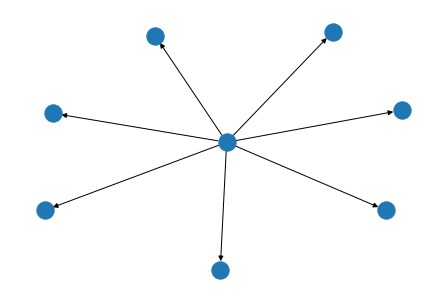

In [28]:
DG = nx.DiGraph()

comp_name = 'URFU_COMP'

for i in list(departments):
    DG.add_edge(comp_name, i)
    

nx.draw(DG)


## Graph styles

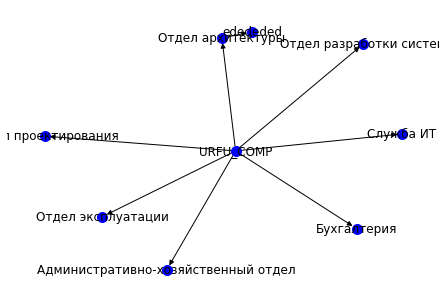

In [38]:
options = {'node_color': 'blue', 'edge_color' : 'black', 'node_size': 50, 'with_labels' : True, 'width': 3, 'node_size' : 100, 'width': 1}
pos=nx.spring_layout(DG)

nx.draw(DG,pos=pos,**options)


## Multilevel graph

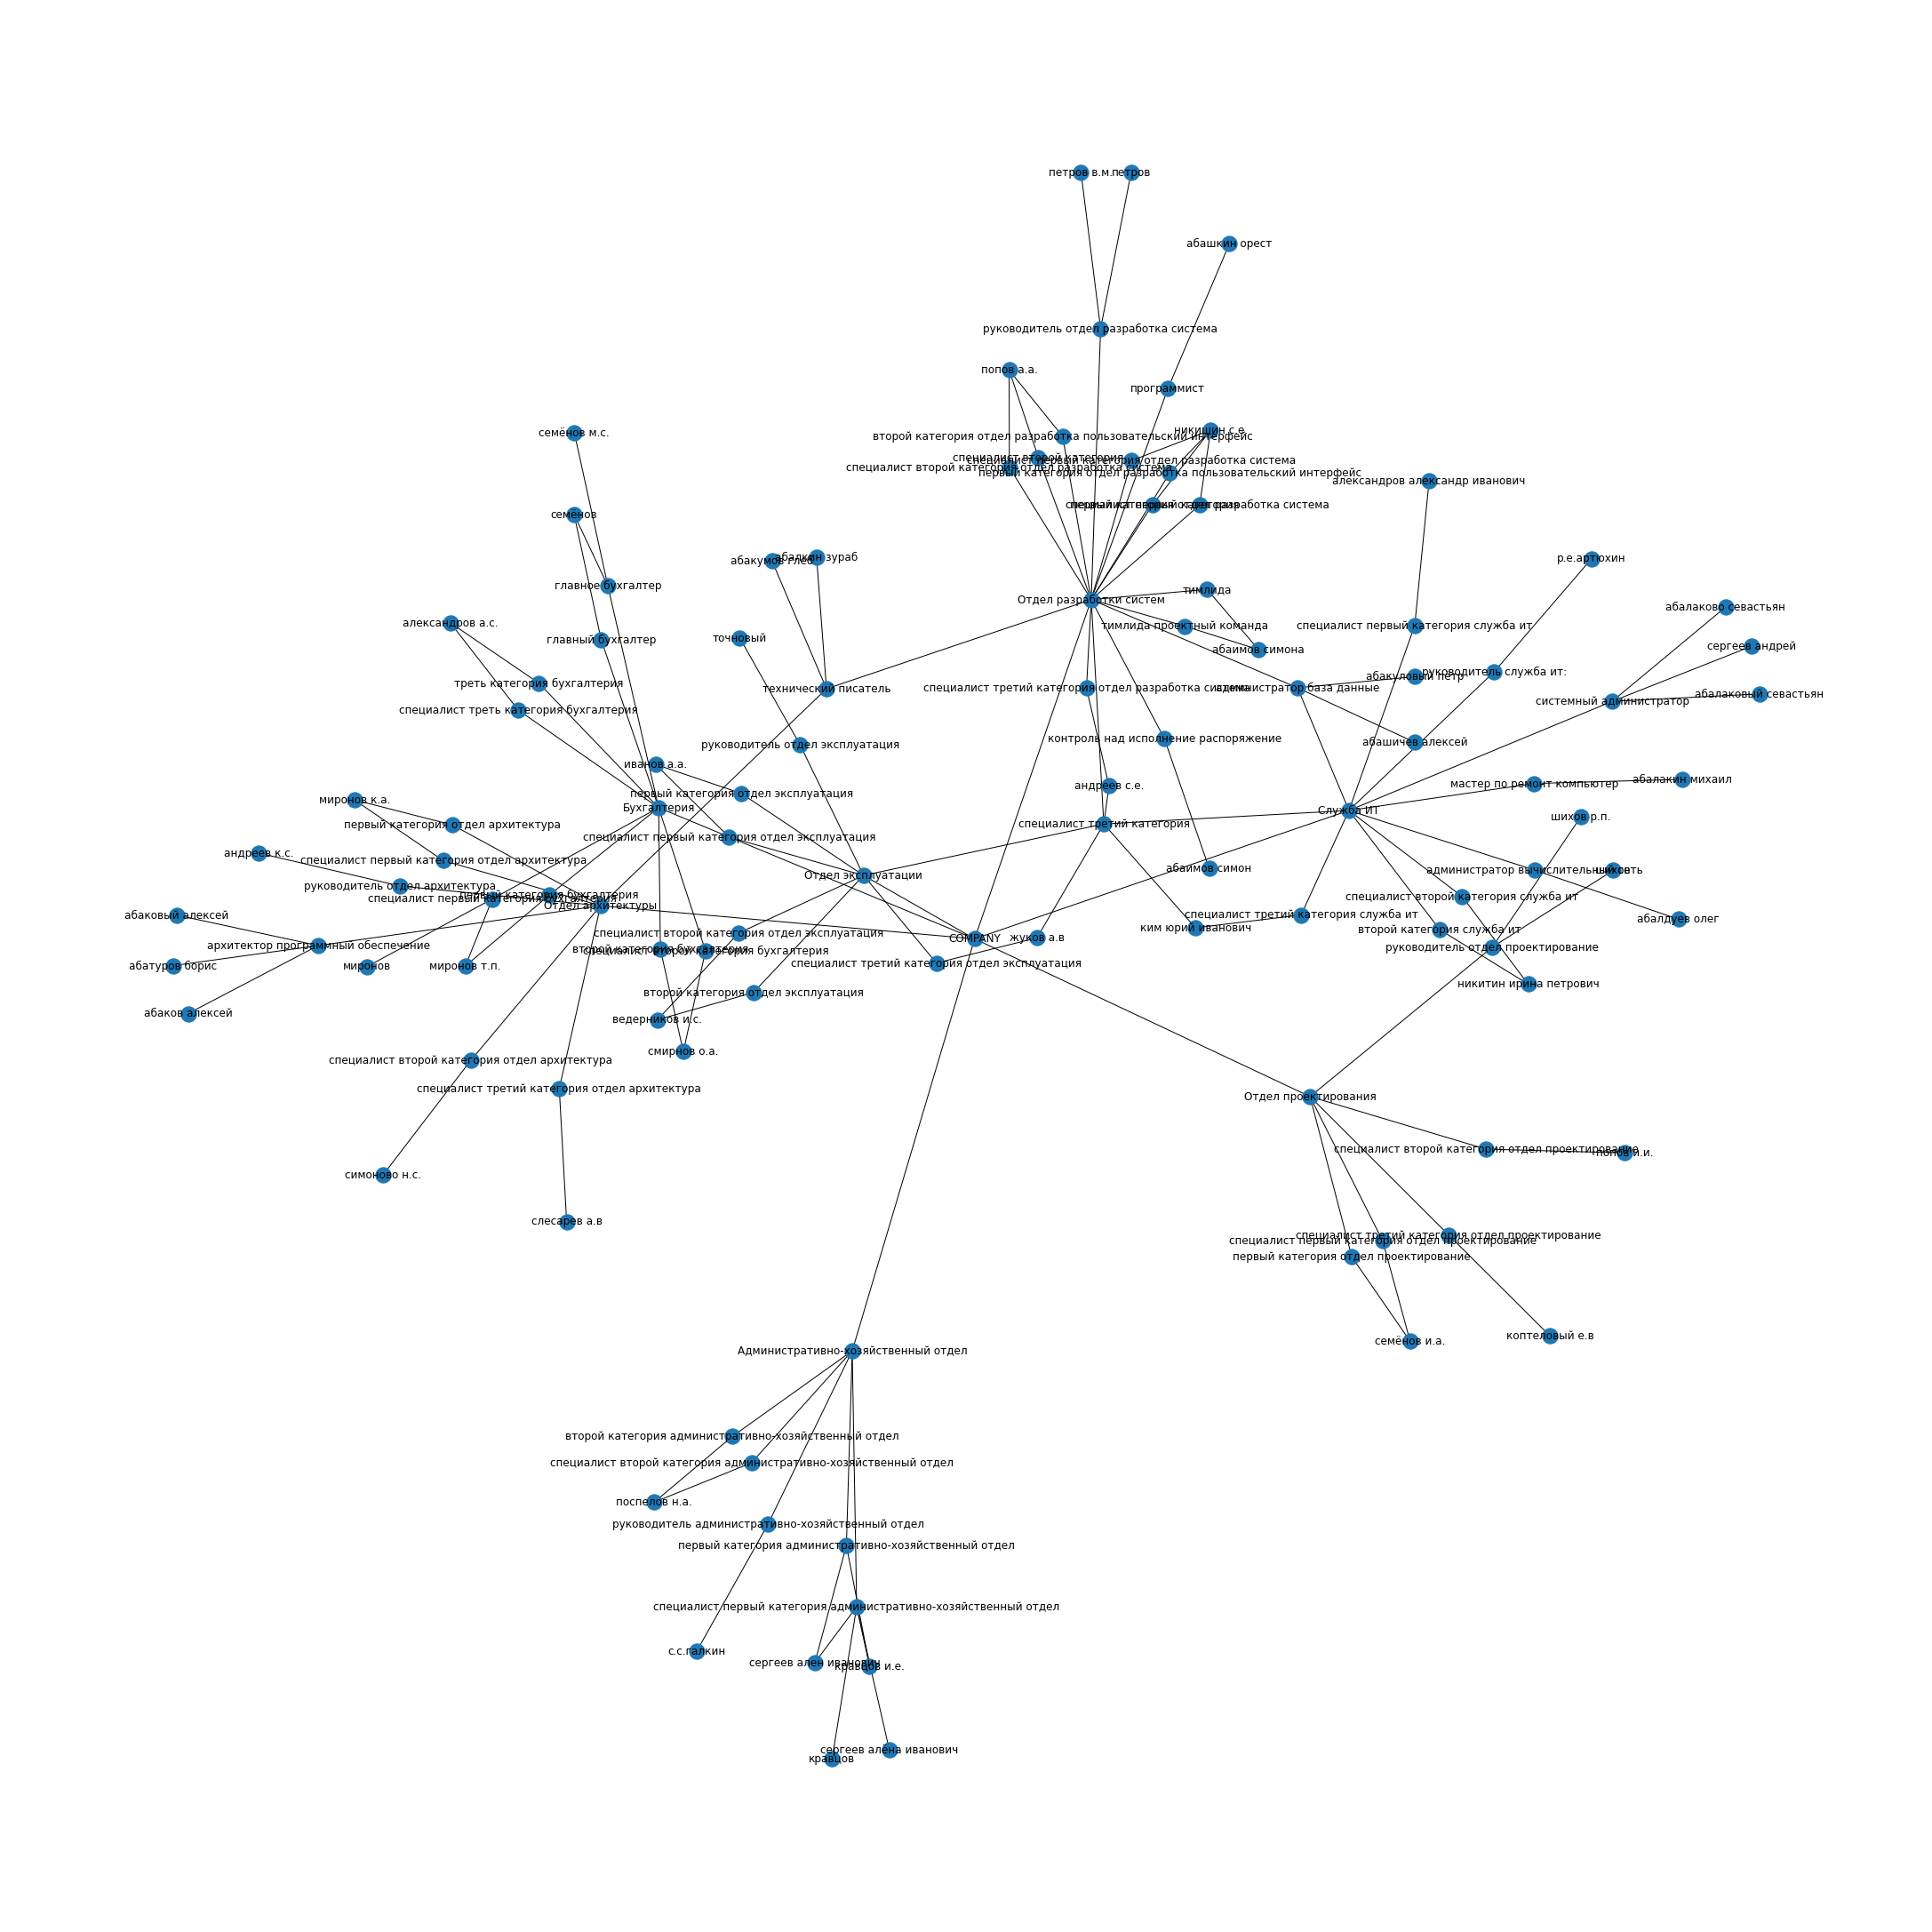

In [42]:

# create a graph object
G = nx.Graph()


comp_name = 'COMPANY'


for z in list(departments):
    G.add_edge(comp_name, z)
    # iterate through the rows of the DataFrame
    for i, row in df.iterrows():
        # add task_responsibles_groups node
        dept = row["dept"]
        G.add_node(dept, size=df["dept"].value_counts()[dept])
        # add position node
        position = row["position"]
        G.add_node(position, size=df["position"].value_counts()[position])
        # add name node
        name = row["name"]
        G.add_node(name, size=df["name"].value_counts()[name])
        # add edges between task_responsibles_groups and position
        G.add_edge(dept, position)
        # add edges between position and name
        G.add_edge(position, name)


# draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30)) # set the size of the figure
pos = nx.spring_layout(G) # use spring layout to calculate node positions
nx.draw(G, pos, with_labels=True)